# Building CNN From Scratch With Keras For Cancer Detection
***By Kris Smith***

## Import Libraries

In [1]:
import numpy as np, pandas as pd
import os
import cv2
from PIL import Image ## For working with images
from glob import glob 
import matplotlib.pyplot as plt
%matplotlib inline

#############################################################
import os, cv2
from scipy import stats

from tqdm import tqdm_notebook,trange

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


---

# EDA

## Load Data

In [2]:
print(f'Total Number of Samples in Training Data = {len(os.listdir("../input/histopathologic-cancer-detection/train"))}')
print(f'Total Number of Samples in Test Data = {len(os.listdir("../input/histopathologic-cancer-detection/test"))}')

Total Number of Samples in Training Data = 220025
Total Number of Samples in Test Data = 57458


In [3]:
path = "../input/histopathologic-cancer-detection/"
train_path = path + 'train/'
test_path = path + 'test/'

### Read data into pandas frames ###
## Load training and testing file names into frames
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) 
df_test = pd.DataFrame({'path': glob(os.path.join(test_path,'*.tif'))}) 

## Isolate the id from file names and store as id features in seperate column
df['id'] = df.path.map(lambda x: x.split('/')[4].split(".")[0]) 

## Read in training labels
labels = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

## Add Labels to training data 
df = df.merge(labels, on = "id") # merge labels and filepaths
df.sample(7)

,path,id,label
60570,../input/histopathologic-cancer-detection/trai...,d4d562d463597182840729848ecbe50b93df6114,1
151101,../input/histopathologic-cancer-detection/trai...,7b2426ec5a9f3b6a8f80bfe5f69f3a5983869e40,0
168436,../input/histopathologic-cancer-detection/trai...,57aca0764cd536630f9f651ab4310342efcfe9f6,0
218514,../input/histopathologic-cancer-detection/trai...,3ed39bba5fa9810c75e7ccf29a2ed506828abb64,1
12969,../input/histopathologic-cancer-detection/trai...,c84737e62d92d217c2912363ecf55171637a5d8a,1
116897,../input/histopathologic-cancer-detection/trai...,6a4a4e781a966540e4dd746ad0b45ea60b08bd17,0
133504,../input/histopathologic-cancer-detection/trai...,99aef8efa16d7a5c68c0eb76b78835caadf03682,0


## Lets Inspect Distribution Among The Classes in Training Data

<AxesSubplot: title={'center': 'Class Distribution in Training Data'}>

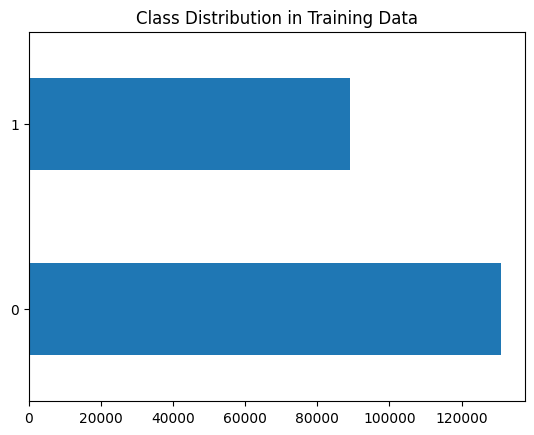

In [4]:
labels['label'].value_counts().plot(kind='barh', title='Class Distribution in Training Data')

## Inspect Some Samples From Both Positive and Negative Classes

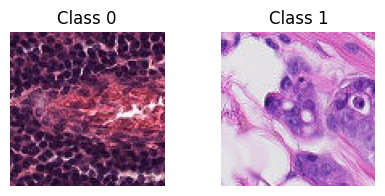

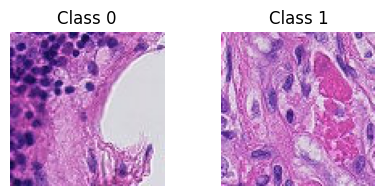

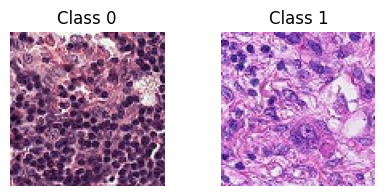

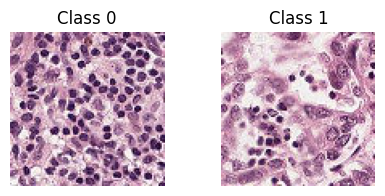

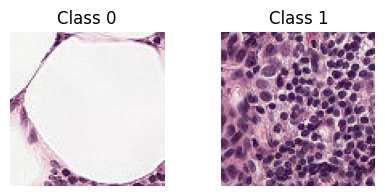

In [11]:
## Filter dataframe to get a subset of each class
class0 = df[df['label'] == 0]
class1 = df[df['label'] == 1]

for image in range(5):
    ## Select a random sample from each class
    sample0 = class0.sample(1)
    sample1 = class1.sample(1)

    ## Open image files and plot
    img_path0 = sample0['path'].values[0]
    img_path1 = sample1['path'].values[0]

    img0 = Image.open(img_path0)
    img1 = Image.open(img_path1)

    fig, ax = plt.subplots(1, 2, figsize=(5, 2))

    ax[0].imshow(img0)
    ax[0].set_title('Class 0')
    ax[0].axis('off')

    ax[1].imshow(img1)
    ax[1].set_title('Class 1')
    ax[1].axis('off')

    plt.show()